In [1]:
import numpy as np
import matplotlib.pyplot as plt

from roboticstoolbox import models
import roboticstoolbox as rtb



In [2]:
robot = models.DH.UR5()

In [3]:
# Массы звеньев (кг)
masses = [3.7, 6.8, 4.8, 0.8, 0.8, 0.8]

# Центр масс каждого звена (в локальной системе координат)
centers_of_mass = [
    [0, 0, -0.08],   # Звено 1
    [0, -0.12, 0],   # Звено 2
    [0, 0, -0.12],   # Звено 3
    [0, 0, 0],       # Звено 4
    [0, 0, 0],       # Звено 5
    [0, 0, 0]        # Звено 6
]

# Тензоры инерции (Lxx, Lyy, Lzz, Lxy, Lyz, Lxz)
inertias = [
    [0.0, 0.09, 0.09, 0, 0, 0],         # Звено 1
    [0.23, 0.2, 0.03, 0, 0, 0],         # Звено 2
    [0.02, 0.02, 0.03, 0, 0, 0],        # Звено 3
    [0.001, 0.001, 0.001, 0, 0, 0],     # Звено 4
    [0.001, 0.001, 0.001, 0, 0, 0],     # Звено 5
    [0.001, 0.001, 0.001, 0, 0, 0]      # Звено 6
]

# Момент инерции двигателей (примерно)
Jm = [0.0001, 0.0004, 0.0001, 0.00001, 0.00001, 0.00001]

# Коэффициенты вязкого трения
B = [0.1, 0.1, 0.05, 0.01, 0.01, 0.01]

# Коэффициенты кулоновского трения (±)
Tc = [0.3, 0.5, 0.3, 0.1, 0.1, 0.1]

# Передаточные числа редукторов
G = [100, 100, 100, 50, 50, 50]

# Ограничения по обобщенным координатам (радианы)
qlim = [
    [-np.pi, np.pi],
    [-np.pi, np.pi],
    [-np.pi, np.pi],
    [-np.pi, np.pi],
    [-np.pi, np.pi],
    [-np.pi, np.pi]
]

# Присвоение динамических параметров каждому звену
for i in range(6):
    robot.links[i].m = masses[i]
    robot.links[i].r = centers_of_mass[i]
    robot.links[i].I = inertias[i]
    robot.links[i].Jm = Jm[i]
    robot.links[i].B = B[i]
    robot.links[i].Tc = Tc[i]
    robot.links[i].G = G[i]
    robot.links[i].qlim = qlim[i]

In [4]:
# Произвольные начальная и конечная конфигурации
q_start = np.array([0, -np.pi/2, np.pi/2, 0, np.pi/2, 0])
q_end = np.array([np.pi/2, -np.pi/3, np.pi/3, 0, np.pi/2, 0])


In [5]:
# Задание временного массива
dt = 0.1
mT = 1
steps = int(mT / dt)
time_array = np.linspace(0, mT, steps)


In [6]:
tr_1 = rtb.mtraj(rtb.trapezoidal, q_start, q_end, time_array)

In [7]:
q_d_array = tr_1.q
qd_d_array = tr_1.qd
qdd_d_array = tr_1.qdd


In [8]:
Kp = np.diag([470000, 497000, 19000, 37000, 39700, 19000])
Kd = np.diag([30000, 10000, 800, 50, 2, 2])

def regfunc(robot, t, q_act, qd_act):
    idx = min(int(t / dt), len(q_d_array) - 1)

    q_d = q_d_array[idx]
    qd_d = qd_d_array[idx]
    qdd_d = qdd_d_array[idx]
    
    e = q_d - q_act
    ed = qd_d - qd_act

    M = robot.inertia(q_act)
    C = robot.coriolis(q_act, qd_act) @ qd_d
    G = robot.gravload(q_act)

    tau = M @ qdd_d + C + G + Kp @ e + Kd @ ed
    return tau


In [9]:
tg = robot.fdyn(
    T=mT,
    q0=q_start,
    Q=regfunc,
    qd0=np.zeros(6),
    dt=dt,
    solver="RK45",
    solver_args={"atol": 1e-3, "rtol": 1e-2},
    progress=True
)


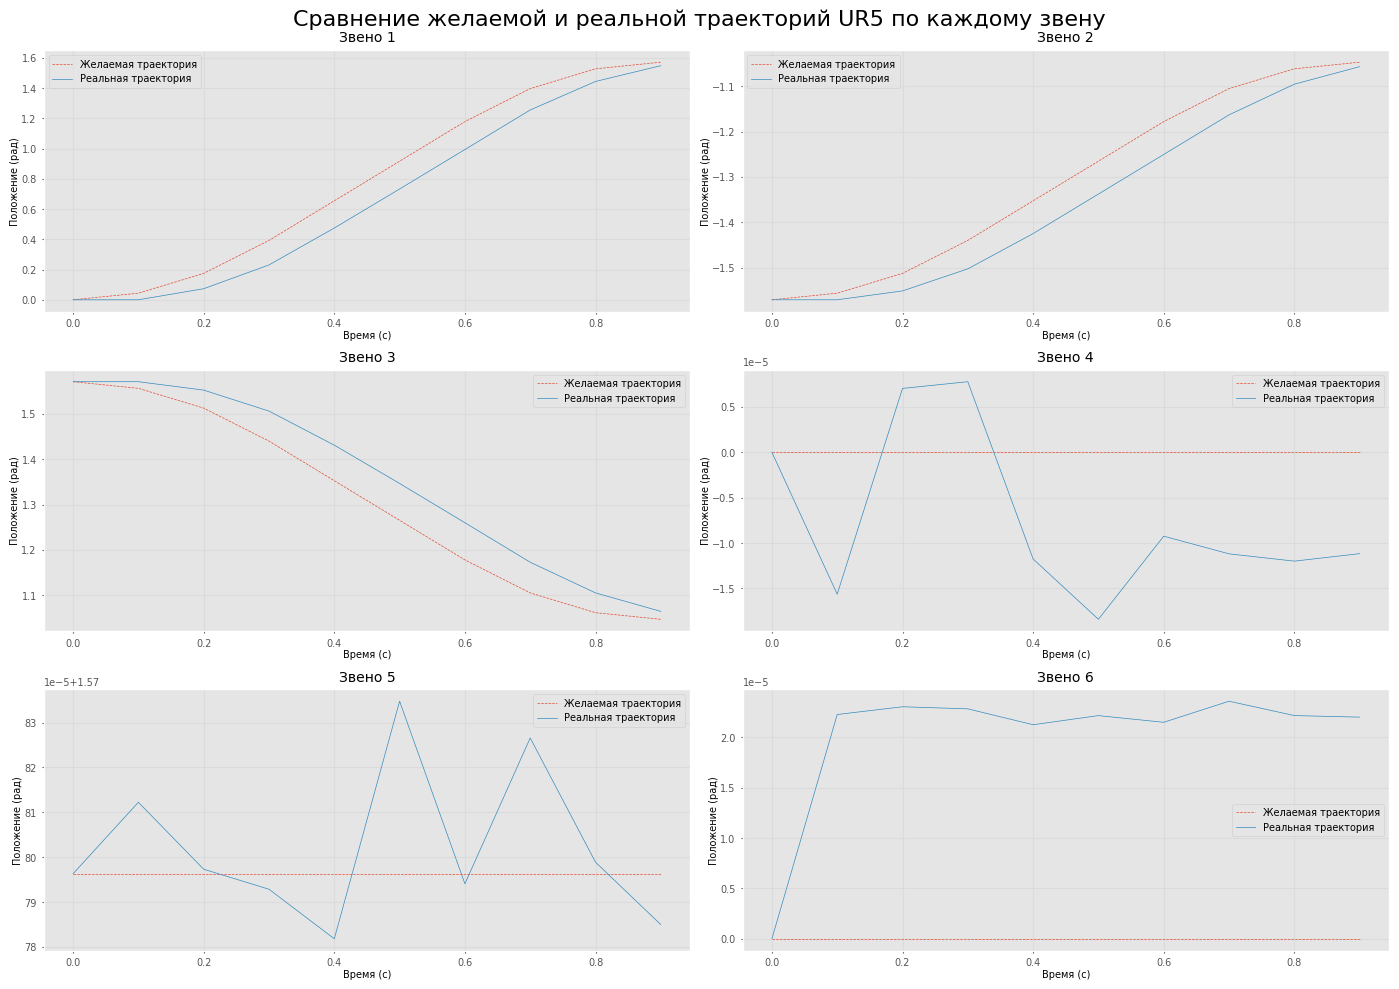

In [10]:
q_sim = np.array(tg.q)


min_len = min(len(tg.t), len(q_d_array))
t_vis = tg.t[:min_len]
q_sim_vis = q_sim[:min_len]
q_des_vis = q_d_array[:min_len]

fig, axs = plt.subplots(3, 2, figsize=(14, 10))
axs = axs.flatten()

for i in range(6):
    axs[i].plot(t_vis, q_des_vis[:, i], '--', label='Желаемая траектория')
    axs[i].plot(t_vis, q_sim_vis[:, i], label='Реальная траектория')
    axs[i].set_title(f'Звено {i+1}')
    axs[i].set_xlabel("Время (с)")
    axs[i].set_ylabel("Положение (рад)")
    axs[i].grid(True)
    axs[i].legend()

plt.suptitle("Сравнение желаемой и реальной траекторий UR5 по каждому звену", fontsize=16)
plt.tight_layout()
plt.show()